To Do:
* Confusion matrix diagram for best model
* Add explanation for why to use SMOTE, options of over and/or under sampling.
* Add in other models to this notebook

# Library Install

We need to install a previous version of matplotlib, otherwise seaborn heatmaps/confusion matrix will be broken

In [18]:
pip install matplotlib==3.1.0

Note: you may need to restart the kernel to use updated packages.


In [ ]:
pip install xgboost

# Functions to move

In [176]:
def best_model_score(clf, param_grid, X_train, y_train, X_test, y_test, scoring='f1', cv=3, n_jobs=-1):
    '''Conducts Gridsearch to return the best test data accuracy and f1 score for a classifier as well as y_pred'''
    
    # Create GridSearch Object
    grid_clf = GridSearchCV(clf, 
                            param_grid, 
                            scoring='f1', 
                            cv=cv
                           )

    # Fit our GridSearch Object and pass  in the training data
    grid_clf.fit(X_train, y_train)

    # Predict on test data
    y_pred = grid_clf.predict(X_test)
    y_pred_proba = grid_clf.predict_proba(X_test)
    
    # Best F1 Score
    best_f1 = f1_score(y_test, y_pred)
    print('Best Test Data F1 score: {}'.format(round(best_f1, 5)))
    print('\nOptimal parameters:')
    best_parameters = grid_clf.best_estimator_.get_params()
    for param_name in sorted(param_grid.keys()):
        print('\t{}: {}'.format(param_name, best_parameters[param_name]))    
    
#     # Classification report
#     print('\n', classification_report(y_test, y_pred))
    
    return best_f1, y_pred, y_pred_proba

In [172]:
def combination_for_best_f1_score(df):
    ''' Return the highest f1 score and print the associated combination of resampling and classifier'''
    index_positions = []
    max_f1 = df.max().max()
    
    # Find where the max F1 score is (NB could be more than one max value)
    df_bool_max_f1 = df.isin([max_f1])
    # Find index/classifier that contains the max F1 score
    best_classifier_row = df_bool_max_f1.any()
    best_classifier_name = list(best_classifier_row[best_classifier_row == True].index)
    # Iterate over list of columns and fetch the rows indexes where value exists
    for col in best_classifier_name:
        rows = list(df_bool_max_f1[col][df_bool_max_f1[col] == True].index)
        for row in rows:
            index_positions.append((row, col))
    
    print('The highest F1 score was {}'.format(round(max_f1, 4)))
    best_classifier = index_positions[0][0]
    best_resampling = index_positions[0][1]
    print('This was achieved by resampling with {} and using the {} classifier'.format(best_resampling, best_classifier))
        
    return max_f1

# Library Imports

In [74]:
# Dataframes
import pandas as pd
import numpy as np

# Graphing
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

# Data Preparation
    # Train:Test
from sklearn.model_selection import train_test_split
    # Scaling
from sklearn.preprocessing import RobustScaler

# Resampling
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter

# Model Tuning and Cross Validation
from imblearn.pipeline import make_pipeline, Pipeline
from sklearn.model_selection import GridSearchCV

# # Model metrics
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report, roc_curve, auc, precision_recall_curve
from sklearn.metrics import plot_confusion_matrix

# # Classifiers
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier



In [76]:
random_seed = 1

# Import Cleaned Data 

In [245]:
df = pd.read_csv('../data/processed/cleaned_dataframe.gz', compression='gzip')
df.head(3)

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0


# Train:Test Split

In [246]:
X = df.drop(['Class'], axis=1)
y = df['Class']

X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size=0.3, 
                                                    stratify=y, 
                                                    random_state=random_seed)

print("No. of samples in each training set:\t{}".format(X_train.shape[0]))
print("No. of samples in each test set:\t{}".format(X_test.shape[0]))

No. of samples in each training set:	199364
No. of samples in each test set:	85443


* We choose to stratify as we want to keep the distribution of classes the same in the training set as the test set. 

# Scaling

* Scaling the data will improve the predictive performance of some machine learning models.  
    * Without scaling, gradient-based estimating models (such as linear or logistic regression) will take longer to converge or may not be able to converge at all.

In [115]:
scaler = RobustScaler()

* As seen earlier with the "Distribution of Amount", the data is not normally distributed and there are a lot of outliers in our data, so we have chosen to use Robust Scaling, rather than Standard Scaling.

In [116]:
# Fit scaler on training data and transform Training data
X_train = scaler.fit_transform(X_train)

# Use the scaler to transform the Test data
X_test = scaler.transform(X_test)

# Resampling

* Resampling the data will improve the effectiveness of many machine learning models.
* Resampling involves drawing repeated samples from the original dataset to create a new dataset which either reduces the ratio of the majority class (undersampling) or increases the ratio of the minority class (oversampling).  A combination of the two can also be used.
* Often undersampling will produce better results, but with such imbalanced data we will choose to oversample for this dataset, as it means we are not losing any data from the original dataset.
* Synthetic Minority Oversampling TEchnique (SMOTE) will be used to produce a more class-balanced dataset.
* Note that we must not resample the test data, as it represents unseen data.  If it is unseen, we will not know which class it falls in, and thus we will not know whether to undersample or oversample it.

In [121]:
# summarize class distribution before resampling
counter = Counter(y_train)
print('Distribution of data before resampling:')
ratio = round(counter[0]/counter[1], 1)
print('\t0: {}\t1: {}\t\t({} : 1)'.format(counter[0], counter[1], ratio))

# Resample the dataset with SMOTE
resample_smote = SMOTE(sampling_strategy='auto', random_state=random_seed)
resample_smote.fit(X_train, y_train)
X_train_smote, y_train_smote = resample_smote.fit_resample(X_train, y_train)
counter = Counter(y_train_smote)
print('Distribution after SMOTE:')
ratio = round(counter[0]/counter[1], 1)
print('\t0: {}\t1: {}\t({} : 1)'.format(counter[0], counter[1], ratio))

# Resample the dataset with Random Undersampling
resample_under = RandomUnderSampler(sampling_strategy='auto', random_state=random_seed)
resample_under.fit(X_train, y_train)
X_train_under, y_train_under = resample_under.fit_resample(X_train, y_train)
counter = Counter(y_train_under)
print('Distribution after Random Undersampling:')
ratio = round(counter[0]/counter[1], 1)
print('\t0: {}\t\t1: {}\t\t({} : 1)'.format(counter[0], counter[1], ratio))

# Resample the dataset with SMOTE and Random Undersampling
over = SMOTE(sampling_strategy=0.1, random_state=random_seed)
under = RandomUnderSampler(sampling_strategy=0.5, random_state=random_seed)
steps = [('o', over), ('u', under)]
resample_smote_under = Pipeline(steps=steps)
resample_smote_under.fit(X_train, y_train)
X_train_smote_under, y_train_smote_under = resample_smote_under.fit_resample(X_train, y_train)
counter = Counter(y_train_smote_under)
print('Distribution after SMOTE and Random Undersampling:')
ratio = round(counter[0]/counter[1], 1)
print('\t0: {}\t1: {}\t({} : 1)'.format(counter[0], counter[1], ratio))

Distribution of data before resampling:
	0: 199020	1: 344		(578.5 : 1)
Distribution after SMOTE:
	0: 199020	1: 199020	(1.0 : 1)
Distribution after Random Undersampling:
	0: 344		1: 344		(1.0 : 1)
Distribution after SMOTE and Random Undersampling:
	0: 39804	1: 19902	(2.0 : 1)


# Modeling

## Pandas Dataframe to keep track of Scores

In [122]:
# Build scores dataframe for comparison
scores_columns = ['SMOTE', 'Undersampled', 'SMOTE & Undersampled']
scores_df = pd.DataFrame(columns=scores_columns)

## GridSearch

* The function we use makes use of sklearn's GridSearchCV function.  
* Grid Search is an exhaustive search using the parameter values that we provide, in order to optimize our model
    * Not every possible parameter combination is tested, so we can not guarantee a globally optimal combination of parameter values.
    * The model will ony be as good as the possible combinations of parameters that we provide.

## Baseline Model & Model Metrics

The Baseline Model predicts that every observation is only the majority Class (non-fraud).  Due to the high imbalance of the dataset, our baseline model will return a very high accuracy.  

In [123]:
# Baseline model that all predictions are majority class
y_pred_base = [0] * len(y_test)

# Calculate Accuracy of Baseline Model
acc_base = round(accuracy_score(y_test, y_pred_base), 5)
print('Baseline Model Accuracy: {}'.format(acc_base))

Baseline Model Accuracy: 0.99827


The best model will catch as many frauds as possible while minimizing the number of transactions flagged as fraud that are actually legitimate.

If we want to know how well a model predicts the minority class (fraud), F1 is the most useful metric. F1 is a weighted average of *Precision* and *Recall*, measure between 0 and 1 with a score of 1 being the best.

### Precision 
\begin{equation*}
\frac{True Positives}{True Positives + False Positives}
\end{equation*}

### Recall
\begin{equation*}
\frac{True Positives}{True Positives + False Negatives}
\end{equation*}

### F1 Score
\begin{equation*}
2*\frac{Precision * Recall}{Precision + Recall}
\end{equation*}

We also looked at Precision-Recall curves to get a sense of how well the model captures true positives. A PR curve plots the Precision and Recall scores across different thresholds for a positive identification. This helps us to see whether a model captures true positives while minimizing false positives and false negatives.

In [124]:
# Calculate F1 Score of Baseline Model
f1_base = round(f1_score(y_test, y_pred_base), 8)
print('Baseline Model F1 Score: {}'.format(f1_base))

Baseline Model F1 Score: 0.0


This baseline F1 Score is terrible as both Precision and Recall are equal to 0

In [125]:
scores_df.loc['Baseline'] = [f1_base] * 3
scores_df

,SMOTE,Undersampled,SMOTE & Undersampled
Baseline,0.0,0.0,0.0


## Gaussian Naive Bayes

In [85]:
# Instantiate Gaussian Naive Bayes Classifer
clf_gnb = GaussianNB()

# Build Parameter Grid
param_grid_gnb = {}

### Gaussian Naive Bayes - SMOTE

In [177]:
# Gaussian Bayes with SMOTE training data
f1_gnb_smote, y_pred_gnb_smote, y_pred_proba_gnb_smote = best_model_score(clf_gnb, param_grid_gnb, X_train_smote, y_train_smote, X_test, y_test)

Best Test Data F1 score: 0.10399

Optimal parameters:


### Gaussian Naive Bayes - RandomUndersampling

In [178]:
# Gaussian Bayes with Undersampled training data
f1_gnb_under, y_pred_gnb_under, y_pred_proba_gnb_under = best_model_score(clf_gnb, param_grid_gnb, X_train_under, y_train_under, X_test, y_test)

Best Test Data F1 score: 0.0723

Optimal parameters:


### Gaussian Naive Bayes - SMOTE & RandomUndersampling

In [179]:
# Gaussian Bayes with SMOTE and Undersampled training data
f1_gnb_smote_under, y_pred_gnb_smote_under, y_pred_proba_gnb_smote_under = best_model_score(clf_gnb, param_grid_gnb, X_train_smote_under, y_train_smote_under, X_test, y_test)

Best Test Data F1 score: 0.10441

Optimal parameters:


In [180]:
# Add F1 Scores to scores dataframe
scores_df.loc['Gaussian Naive Bayes'] = [f1_gnb_smote, f1_gnb_under, f1_gnb_smote_under]
scores_df

,SMOTE,Undersampled,SMOTE & Undersampled
Baseline,0.000000,0.000000,0.000000
Gaussian Naive Bayes,0.103990,0.072303,0.104411
Random Forest,0.877551,0.090030,0.786787
XGBoost,0.845638,0.090293,0.715447


## Random Forest

A Random Forest classifier uses an ensemble of decision trees that are trained using different portions of the data and different combinations of features. The forests predicts based on what the majority of trees in the forest predict.

In [90]:
# Instantiate Random Forest Classifer
clf_rf = RandomForestClassifier()

# Build Parameter Grid
param_grid_rf = {'n_estimators': [30], 
                  'class_weight': [{0: 1, 1: 2}],
                  'clf__criterion': ['gini', 'entropy'], 
                   'clf__min_samples_leaf': [1], 
                   'clf__max_depth': [None], 
                   'clf__min_samples_split': [2]
                  }

Class weights ensure that there is a higher penalty for misclassifying instances of fraud.

In [93]:
# Instantiate Random Forest Classifer
clf_rf = RandomForestClassifier(n_estimators=30, n_jobs=n_jobs)

# Build Parameter Grid
param_grid_rf = {}

### Random Forest - SMOTE

In [186]:
f1_rf_smote, y_pred_rf_smote, y_pred_proba_rf_smote = best_model_score(clf_rf, param_grid_rf, X_train_smote, y_train_smote, X_test, y_test)

Best Test Data F1 score: 0.87372

Optimal parameters:


### Random Forest - RandomUndersampling

In [134]:
f1_rf_under, y_pred_rf_under, y_pred_proba_rf_under = best_model_score(clf_rf, param_grid_rf, X_train_under, y_train_under, X_test, y_test)

Best Test Data F1 score: 0.09003

Optimal parameters:


### Random Forest - SMOTE & RandomUndersampling

In [135]:
f1_rf_smote_under, y_pred_rf_smote_under, y_pred_proba_rf_smote_under = best_model_score(clf_rf, param_grid_rf, X_train_smote_under, y_train_smote_under, X_test, y_test)

Best Test Data F1 score: 0.78679

Optimal parameters:


In [136]:
scores_df.loc['Random Forest'] = [f1_rf_smote, f1_rf_under, f1_rf_smote_under]
scores_df

,SMOTE,Undersampled,SMOTE & Undersampled
Baseline,0.000000,0.000000,0.000000
Gaussian Naive Bayes,0.103990,0.072303,0.104411
Random Forest,0.877551,0.090030,0.786787


## XGBoost

In [137]:
# Instantiate XGBClassifier
clf_xgb = XGBClassifier(booster='gbtree', 
                    seed=random_seed
                   )

# Build Parameter Grid
param_grid_xgb = {
    'learning_rate': [0.1, 0.2, 0.3],
    'objective': ['binary:logistic', 'binary:hinge'],
    'max_depth': [5,6,10],
    'min_child_weight': [1,2,3],
}

### XGBoost - SMOTE

In [138]:
f1_xgb_smote, y_pred_xgb_smote, y_pred_proba_xgb_smote = best_model_score(clf_xgb, param_grid_xgb, X_train_smote, y_train_smote, X_test, y_test)

Best Test Data F1 score: 0.84564

Optimal parameters:
	learning_rate: 0.1
	max_depth: 6
	min_child_weight: 2
	objective: binary:hinge


### XGBoost - RandomUndersampling

In [139]:
f1_xgb_under, y_pred_xgb_under, y_pred_proba_xgb_under = best_model_score(clf_xgb, param_grid_xgb, X_train_under, y_train_under, X_test, y_test)

Best Test Data F1 score: 0.09029

Optimal parameters:
	learning_rate: 0.3
	max_depth: 6
	min_child_weight: 2
	objective: binary:logistic


### XGBoost - SMOTE & RandomUndersampling

In [140]:
f1_xgb_smote_under, y_pred_xgb_smote_under, y_pred_proba_xgb_smote_under = best_model_score(clf_xgb, param_grid_xgb, X_train_smote_under, y_train_smote_under, X_test, y_test)

Best Test Data F1 score: 0.71545

Optimal parameters:
	learning_rate: 0.3
	max_depth: 6
	min_child_weight: 1
	objective: binary:logistic


In [141]:
scores_df.loc['XGBoost'] = [f1_xgb_smote, f1_xgb_under, f1_xgb_smote_under]
scores_df

,SMOTE,Undersampled,SMOTE & Undersampled
Baseline,0.000000,0.000000,0.000000
Gaussian Naive Bayes,0.103990,0.072303,0.104411
Random Forest,0.877551,0.090030,0.786787
XGBoost,0.845638,0.090293,0.715447


# Analysis of Results

In [181]:
scores_df

,SMOTE,Undersampled,SMOTE & Undersampled
Baseline,0.000000,0.000000,0.000000
Gaussian Naive Bayes,0.103990,0.072303,0.104411
Random Forest,0.877551,0.090030,0.786787
XGBoost,0.845638,0.090293,0.715447


In [173]:
max_f1 = combination_for_best_f1_score(scores_df)

The highest F1 score was 0.8776
This was achieved by resampling with SMOTE and using the Random Forest classifier


In [315]:
# Save the predictions from the optimal resampling and classifier
y_pred = y_pred_rf_smote

## Confusion Matrix

Confusion Matrix: 
TN: 85278 FP: 17 FN: 19 TP: 129


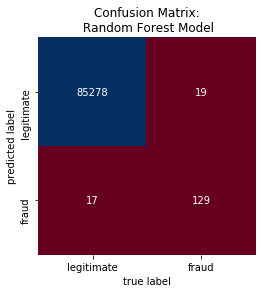

In [184]:
# print confusion matrix    
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm.T, square=True, annot=True, fmt = 'g', cmap='RdBu', cbar=False, xticklabels=['legitimate', 'fraud'], yticklabels=['legitimate', 'fraud'])
plt.title('Confusion Matrix:\n Random Forest Model')
plt.xlabel('true label')
plt.ylabel('predicted label')
plt.savefig('cm_rf_smote')

tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
print("Confusion Matrix:",'\nTN:', tn, 'FP:', fp, 'FN:', fn, 'TP:', tp)

## ROC CURVE

In [188]:
y_pred_proba = y_pred_proba_rf_smote

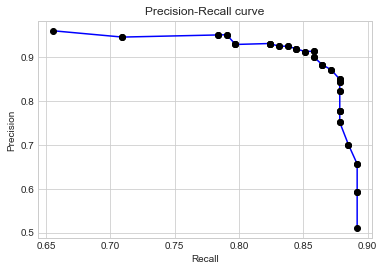

In [189]:
probs = pd.DataFrame(y_pred_proba, columns=['prob_legit', 'prob_fraud'])
probs['actual']=[i for i in y_test]
probs.head()

# # print 
def frange(start, stop, step):
    i = start
    while i < stop:
        yield i
        i += step

names = ['cut_off', 'recall', 'precision']
fraud_metrics = pd.DataFrame()

# for loop to test different cut-off values
for i in frange(.2,.95,.015):
    probs['label'] = np.where(probs['prob_fraud'] >= i, 1, 0)
    tn, fp, fn, tp = confusion_matrix(probs['actual'], probs['label']).ravel()
    recall = tp/(tp+fn)
    precision = tp/(tp+fp)
    evals = [i,recall,precision]
    fraud_metrics=fraud_metrics.append(pd.Series(evals), ignore_index=True)

fraud_metrics.columns = names

import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('seaborn-whitegrid')
# plot the data
plt.plot(fraud_metrics.recall, fraud_metrics.precision , '-', color='blue')
plt.plot(fraud_metrics.recall, fraud_metrics.precision , 'o', color='black')
# make some nice labels
plt.title('Precision-Recall curve')
plt.ylabel('Precision')
plt.xlabel('Recall')
plt.savefig('pr_curve_rf_smote')

In [192]:
# Inspecting the amounts of frauds that our model missed
pred_vs_actual = pd.DataFrame({"Amount": X_test['Amount'], "Predicted": y_pred_rf_smote, "Actual": [i for i in y_test]})
pred_vs_actual.loc[(pred_vs_actual['Predicted']==0) & (pred_vs_actual['Actual']==1)]['Amount'].describe()

IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

In [270]:
pred_vs_actual = pd.DataFrame()
pred_vs_actual['Amount'] = X_test['Amount']
pred_vs_actual['Predictions'] = y_pred
pred_vs_actual['Test Data'] = y_test
pred_vs_actual['Correct'] = (pred_vs_actual['Predictions']==pred_vs_actual['Test Data']).astype(int)
pred_vs_actual.head()

,Amount,Predictions,Test Data,Correct
31773,104.00,0,0,1
117430,16.48,0,0,1
274383,4.00,0,0,1
216704,18.96,0,0,1
245854,4.99,0,0,1


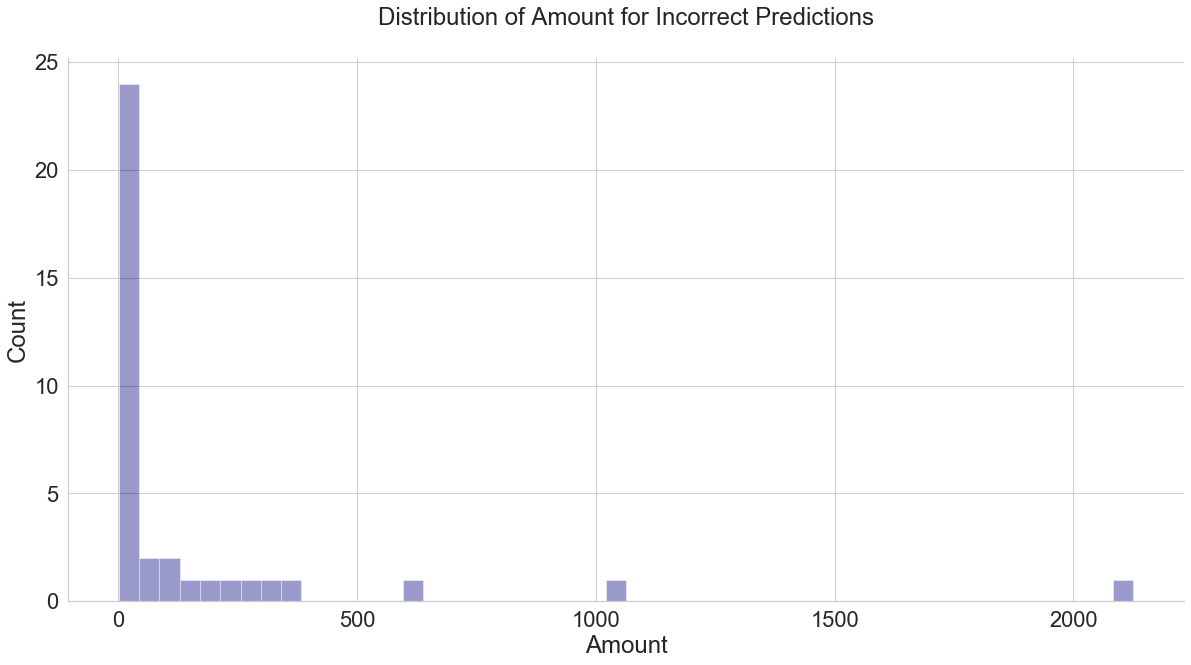

In [314]:
incorrect_predictions = pred_vs_actual['Correct']==0
correct_predictions = pred_vs_actual['Correct']==1

plt.figure(figsize=(20,10))
sns.set(font_scale=2, style='whitegrid', )
ax = sns.distplot(pred_vs_actual[incorrect_predictions]['Amount'], kde=False, color='navy', bins=50)
sns.despine()
plt.ylabel('Count');
ax.set_title('Distribution of Amount for Incorrect Predictions\n',);

## GridSearch

The parameter tuning using GridSearchCV improved our model's performance 
by over 20%, from ~44% to ~66%. The model also shows no signs of 
overfitting, as evidenced by the close training and testing scores. 
Grid Search does not gaurantee that we will always find the globally 
optimal combination of parameter values. Since it only exhaustively 
searches through the parameter values we provide, 
not every possible combination of every possible value for each parameter 
is tested. This means that the model is only as good as the possible 
combinations of the parameters we include in our parameter grid.

 |     Parameter     |         Values         |
|:-----------------:|:----------------------:|
|    n_estimators   |      [10, 30, 100]     |
|     criterion     |   ['gini', 'entropy']  |
|     max_depth     | [None, 2, 6, 10] |
| min_samples_split |       [5, 10]       |
|  min_samples_leaf |   [3, 6]   |

GridSearchCV finds the optimal combination of parameters through an exhaustive combinatoric search. If you search through too many parameters, the model will take forever to run

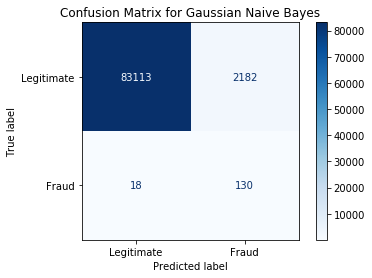

In [21]:
# Plot Confusion Matrix
class_names = ['Legitimate', 'Fraud']

conf_matrx_title = 'Gaussian Naive Bayes'

disp = plot_confusion_matrix(model,
                             X_test,
                             y_test,
                             display_labels=class_names,
                             normalize=None,
                            cmap=plt.cm.Blues)
plt.title('Confusion Matrix for {}'.format(conf_matrx_title));
